In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

from typing import Union, List
from diffSPH.kernels import getKernel
from diffSPH.v2.sphOps import sphOperation
from diffSPH.v2.math import volumeToSupport

from diffSPH.v2.math import mod
# from torchCompactRadius import radiusSearch
# from torchCompactRadius.util import countUniqueEntries

from diffSPH.v2.sampling import sampleRegular
# from torchCompactRadius import radiusSearch
# from torchCompactRadius.util import countUniqueEntries
from diffSPH.v2.sphOps import sphOperation
from diffSPH.v2.math import mod, volumeToSupport
from diffSPH.kernels import getKernel
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.sampling import samplePDF
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.shifting import computeShifting
import numpy as np
import torch

from diffSPH.v2.finiteDifference import computeGradient
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

# def scatterPlot(fig, axis, p, c, domainMin, domainMax, label = None, periodic = True):
#     pos = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - domainMin[i], domainMax[i] - domainMin[i]) + domainMin[i] for i in range(dim)], dim = 1)
#     sc = axis.scatter(pos[:,0], pos[:,1], s = 8, c = c)
#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
#     cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
#     if label is not None:
#         axis.set_title(label)
#     if p.shape[1] > 1:
#         square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
#         axis.add_patch(square)
#     axis.set_aspect('equal')
#     axis.set_xlim(domainMin[0] * 1.05, domainMax[0] * 1.05)
#     axis.set_ylim(domainMin[1] * 1.05, domainMax[1] * 1.05)

# def scatterPlotSymmetric(fig, axis, p, c, domainMin, domainMax, label = None, periodic = True):
#     pos_x = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - domainMin[i], domainMax[i] - domainMin[i]) + domainMin[i] for i in range(dim)], dim = 1)
#     # pos_y = torch.stack([y[:,i] if not periodic_i else torch.remainder(y[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)

#     sc = axis.scatter(pos_x[:,0], pos_x[:,1], s = 8, c = c, vmin = -c.abs().max(), vmax = c.abs().max(), cmap = 'Spectral')
#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
#     cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
#     if label is not None:
#         axis.set_title(label)
#     if p.shape[1] > 1:
#         square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
#         axis.add_patch(square)
#     axis.set_aspect('equal')
#     axis.set_xlim(-1.05,1.05)
#     axis.set_ylim(-1.05,1.05)

In [2]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.sphOps import sphOperationStates
from diffSPH.v2.util import countUniqueEntries
from diffSPH.v2.plotting import plotImplicitSDF
from diffSPH.v2.modules.surfaceDetection import computeColorField, computeColorFieldGradient
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceColorFieldGradient
import matplotlib.pyplot as plt
import torch
import numpy as np
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

config = {
    'domain': {
        'minExtent': -1,
        'maxExtent': 1,
        'dim': 2,
        'periodic': True
    },
    'particle': {
        'nx': 64
    },
    'kernel':{
        'name': 'Wendland2',
    'targetNeighbors': 45.22,
    },
    "neighborhood":{
        "scheme": "compact"
    },
    'EOS':{
        'type': 'Tait',
        'kappa': 1.5
    },
    'shifting':{
        'freeSurface': False
    },
    'boundary':{
        'active':True
    }
}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)

display(config)

{'domain': {'minExtent': tensor([-1., -1.]),
  'maxExtent': tensor([1., 1.]),
  'dim': 2,
  'periodic': True,
  'periodicity': tensor([True, True])},
 'particle': {'nx': 64,
  'dx': tensor(0.0312),
  'kernelScale': tensor(1.8970),
  'defaultVolume': tensor(0.0010),
  'defaultSupport': 0.11856059341027234,
  'volume': tensor(0.0010),
  'support': 0.11856059341027234,
  'smoothingLength': tensor(0.0625)},
 'kernel': {'name': 'Wendland2',
  'targetNeighbors': 45.22,
  'function': <diffSPH.kernels.KernelWrapper at 0x7eff29f1b0d0>,
  'kernelScale': tensor(1.8970)},
 'neighborhood': {'scheme': 'compact', 'verletScale': 1.5},
 'EOS': {'type': 'Tait',
  'kappa': 1.5,
  'gasConstant': 8.14,
  'molarMass': 0.02897,
  'polytropicExponent': 7},
 'shifting': {'freeSurface': False,
  'scheme': 'deltaSPH',
  'R': 0.25,
  'n': 4,
  'CFL': 1.5,
  'computeMach': True,
  'solver': 'BiCGStab_wJacobi',
  'normalScheme': 'lambda',
  'projectionScheme': 'mat',
  'threshold': 0.01,
  'surfaceScaling': 0.1,
  

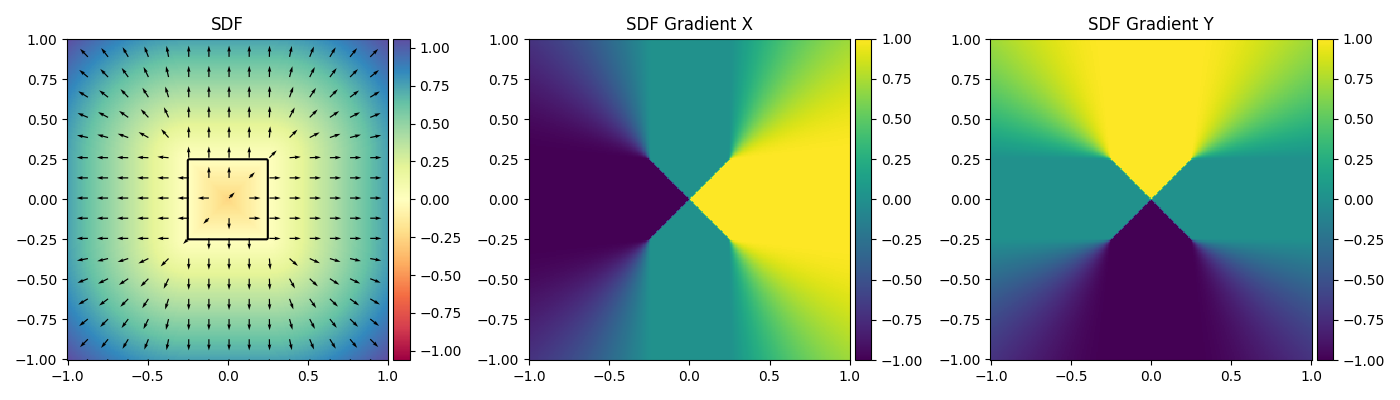

In [3]:
from diffSPH.v2.plotting import *
from diffSPH.noise.generator import generatePerlin, generateSimplex, generateOctaveNoise
from diffSPH.v2.noise import generateNoise

ngrid = 255
x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 0.5)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([0.25,0.25]))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
sdf = sphere_b
plotSDF(sdf(torch.clone(points),), X, Y, 2, 2)

In [4]:
from diffSPH.v2.sampling import sampleParticles, processBoundarySDFs

fluidState,_ = sampleParticles(config)
boundaryState = processBoundarySDFs(fluidState, config, [sdf], 'regular')

# display(boundaryState)

particleState = {
    'fluid': fluidState,
    'boundary': boundaryState,
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
}

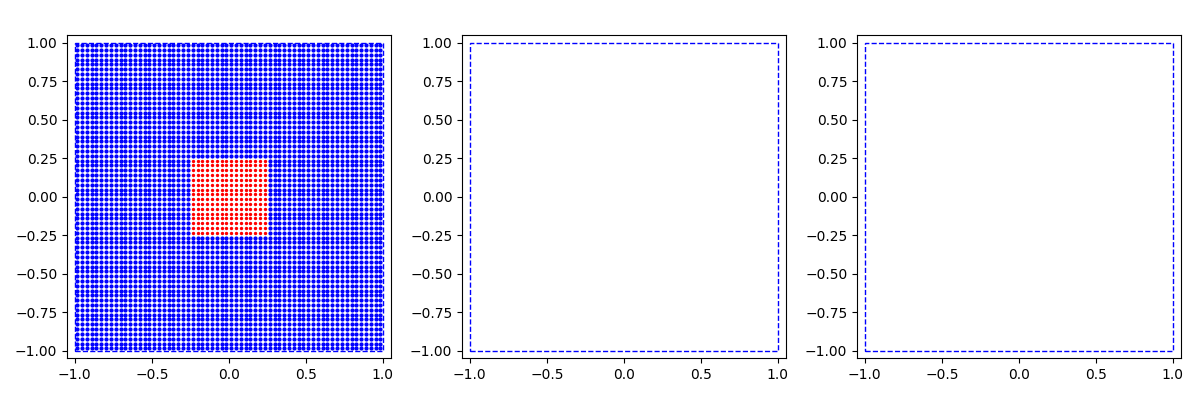

In [5]:
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

for ax in axis.flatten():    
    domainMin = config['domain']['minExtent']
    domainMax = config['domain']['maxExtent']
    square = patches.Rectangle((domainMin[0].detach().cpu().numpy(), domainMin[1].detach().cpu().numpy()), domainMax[0].detach().cpu().numpy() - domainMin[0].detach().cpu().numpy(), domainMax[1].detach().cpu().numpy() - domainMin[1].detach().cpu().numpy(), linewidth=1, edgecolor='b', facecolor='none',ls='--')
    ax.add_patch(square)
    ax.set_aspect('equal')
    ax.set_xlim(-1.05,1.05)
    ax.set_ylim(-1.05,1.05)

axis[0,0].scatter(particleState['boundary']['positions'][:,0].detach().cpu().numpy(), particleState['boundary']['positions'][:,1].detach().cpu().numpy(), c = 'red', s = 2)
axis[0,0].scatter(particleState['fluid']['positions'][:,0].detach().cpu().numpy(), particleState['fluid']['positions'][:,1].detach().cpu().numpy(), c = 'blue', s = 4)

# scatterPlotSymmetric(fig, axis[0,0], boundaryParticles, boundaryParticles.new_ones(boundaryParticles.shape[0]), config['domain']['minExtent'], config['domain']['maxExtent'], '$f(x)$', cmap = 'twilight_r', s = 8)
# scatterPlotSymmetric(fig, axis[0,1], boundaryParticles, boundaryNormals[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\frac{\\partial}{\\partial x} f(x)$', cmap = 'Spectral', s = 8)
# scatterPlotSymmetric(fig, axis[0,2], boundaryParticles, boundaryNormals[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\frac{\\partial}{\\partial y} f(x)$', cmap = 'Spectral', s = 8, cbar = False)

fig.tight_layout()

In [6]:

from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne

from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.sphOps import sphOperationStates
from diffSPH.v2.util import countUniqueEntries
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices, computeCovarianceMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceBarecasco
from diffSPH.v2.math import pinv2x2, scatter_sum
from diffSPH.v2.sphOps import sphOperation, sphOperationStates
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm, densityGradient
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
from diffSPH.v2.modules.viscosity import computeViscosity
from diffSPH.v2.modules.pressureEOS import computeEOS
from diffSPH.v2.modules.pressureForce import computePressureAccel
from diffSPH.v2.modules.gravity import computeGravity
from diffSPH.v2.modules.sps import computeSPSTurbulence
from torch.profiler import record_function


In [7]:
state = copy.deepcopy(particleState)

with record_function("[SPH] - deltaSPH (1 - Neighbor Search)"):
    state['fluid']['neighborhood'] = neighborSearch(state['fluid'], state['fluid'], config, priorNeighborhood = None if 'neighborhood' not in state['fluid'] else state['fluid']['neighborhood'])
    _, state['fluid']['numNeighbors'] = countUniqueEntries(state['fluid']['neighborhood']['indices'][0], state['fluid']['positions'])

    if config['boundary']['active']:
        if not config['boundary']['static']:
            state['boundary']['neighborhood'] = neighborSearch(state['boundary'], state['boundary'], config, priorNeighborhood = None if 'neighborhood' not in state['boundary'] else state['boundary']['neighborhood'])
            _, state['boundary']['numNeighbors'] = countUniqueEntries(state['boundary']['neighborhood']['indices'][0], state['boundary']['positions'])
        
        state['boundaryToFluidNeighborhood'] = neighborSearch(state['fluid'], state['boundary'], config, priorNeighborhood = None if 'boundaryToFluidNeighborhood' not in state else state['boundaryToFluidNeighborhood'])
        _, state['boundaryToFluidNumNeighbors'] = countUniqueEntries(state['boundaryToFluidNeighborhood']['indices'][0], state['fluid']['positions'])
        state['fluidToBoundaryNeighborhood'] = neighborSearch(state['boundary'], state['fluid'], config, priorNeighborhood = None if 'fluidToBoundaryNeighborhood' not in state else state['fluidToBoundaryNeighborhood'])
        _, state['fluidToBoundaryNumNeighbors'] = countUniqueEntries(state['fluidToBoundaryNeighborhood']['indices'][0], state['boundary']['positions'])

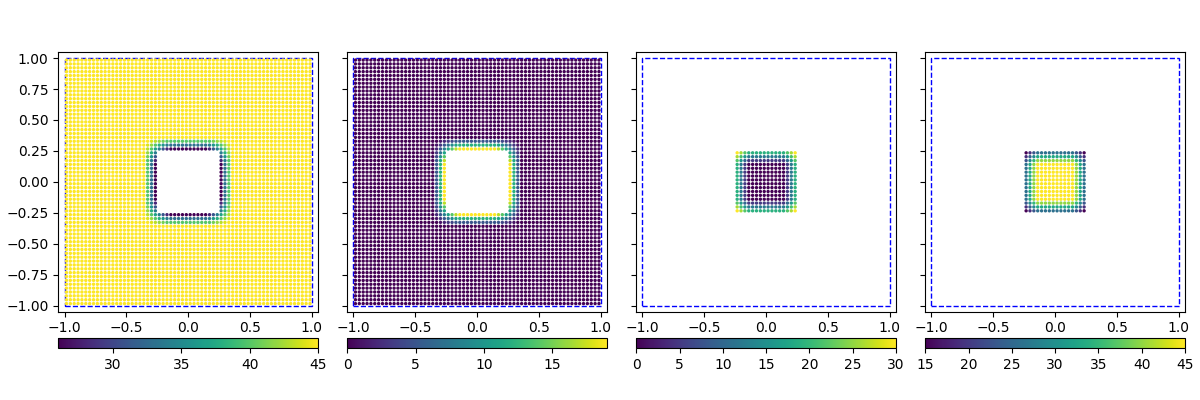

In [8]:
fig, axis = plt.subplots(1, 4, figsize=(12,4), sharex = False, sharey = True, squeeze = False)

for ax in axis.flatten():
    domainMin = config['domain']['minExtent']
    domainMax = config['domain']['maxExtent']
    square = patches.Rectangle((domainMin[0].detach().cpu().numpy(), domainMin[1].detach().cpu().numpy()), domainMax[0].detach().cpu().numpy() - domainMin[0].detach().cpu().numpy(), domainMax[1].detach().cpu().numpy() - domainMin[1].detach().cpu().numpy(), linewidth=1, edgecolor='b', facecolor='none',ls='--')
    ax.add_patch(square)
    ax.set_aspect('equal')
    ax.set_xlim(-1.05,1.05)
    ax.set_ylim(-1.05,1.05)

sc = axis[0,0].scatter(state['fluid']['positions'][:,0].detach().cpu().numpy(), state['fluid']['positions'][:,1].detach().cpu().numpy(), c = state['fluid']['numNeighbors'], s = 2)
cax = make_axes_locatable(axis[0,0]).append_axes("bottom", size="4%", pad="10%")
fig.colorbar(sc, cax=cax,orientation='horizontal')

sc = axis[0,1].scatter(state['fluid']['positions'][:,0].detach().cpu().numpy(), state['fluid']['positions'][:,1].detach().cpu().numpy(), c = state['boundaryToFluidNumNeighbors'], s = 2)
cax = make_axes_locatable(axis[0,1]).append_axes("bottom", size="4%", pad="10%")
fig.colorbar(sc, cax=cax,orientation='horizontal')

sc = axis[0,2].scatter(state['boundary']['positions'][:,0].detach().cpu().numpy(), state['boundary']['positions'][:,1].detach().cpu().numpy(), c = state['fluidToBoundaryNumNeighbors'], s = 2)
cax = make_axes_locatable(axis[0,2]).append_axes("bottom", size="4%", pad="10%")
fig.colorbar(sc, cax=cax,orientation='horizontal')

sc = axis[0,3].scatter(state['boundary']['positions'][:,0].detach().cpu().numpy(), state['boundary']['positions'][:,1].detach().cpu().numpy(), c = state['boundary']['numNeighbors'], s = 2)
cax = make_axes_locatable(axis[0,3]).append_axes("bottom", size="4%", pad="10%")
fig.colorbar(sc, cax=cax,orientation='horizontal')

fig.tight_layout()

In [9]:
from diffSPH.v2.modules.density import computeDensity


def callModule(state, module, config, direction = 'all', reduce = 'sum', **kwargs):
    if direction == 'all':
        if not config['boundary']['active']:
            return module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs), None
        else:
            ftf = module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs)
            # print(f' fluid -> fluid: {ftf.shape}, mean: {ftf.mean()}, min: {ftf.min()}, max: {ftf.max()}')
            btb = module(state['boundary'], state['boundary'], state['boundary']['neighborhood'], config, **kwargs)
            # print(f' boundary -> boundary: {btb.shape}, mean: {btb.mean()}, min: {btb.min()}, max: {btb.max()}')
            btf = module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs)
            # print(f' boundary -> fluid: {btf.shape}, mean: {btf.mean()}, min: {btf.min()}, max: {btf.max()}')
            ftb = module(state['boundary'], state['fluid'], state['fluidToBoundaryNeighborhood'], config, **kwargs)
            # print(f' fluid -> boundary: {ftb.shape}, mean: {ftb.mean()}, min: {ftb.min()}, max: {ftb.max()}')

            if reduce == 'sum':
                return ftf + btf, btb + ftb
            elif reduce == 'min':
                return torch.min(ftf, btf), torch.min(btb, ftb)
            elif reduce == 'max':
                return torch.max(ftf, btf), torch.max(btb, ftb)
            else:
                raise ValueError(f"Invalid reduce {reduce}")
            
    if direction == 'fluid':
        return module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs), None
    if direction == 'fluidwBoundary':
        ftf = module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs)
        btf = module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs)
        if reduce == 'sum':
            return ftf + btf, None
        elif reduce == 'min':
            return torch.min(ftf, btf), None
        elif reduce == 'max':
            return torch.max(ftf, btf), None
        else:
            raise ValueError(f"Invalid reduce {reduce}")
    if direction == 'boundary':
        return None, module(state['boundary'], state['boundary'], state['boundary']['neighborhood'], config, **kwargs)
    if direction == 'boundarywFluid':
        btb = module(state['boundary'], state['boundary'], state['boundary']['neighborhood'], config, **kwargs)
        ftb = module(state['boundary'], state['fluid'], state['fluidToBoundaryNeighborhood'], config, **kwargs)
        if reduce == 'sum':
            return None, btb + ftb
        elif reduce == 'min':
            return None, torch.min(btb, ftb)
        elif reduce == 'max':
            return None, torch.max(btb, ftb)
        else:
            raise ValueError(f"Invalid reduce {reduce}")
    if direction == 'fluidToBoundary':
        return None, module(state['boundary'], state['fluid'], state['fluidToBoundaryNeighborhood'], config, **kwargs)
    if direction == 'boundaryToFluid':
        return module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs), None
    if direction == 'oneWay':
        ftf = module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs)
        btf = module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs)
        if reduce == 'sum':
            return ftf + btf, None
        elif reduce == 'min':
            return torch.min(ftf, btf), None
        elif reduce == 'max':
            return torch.max(ftf, btf), None
        else:
            raise ValueError(f"Invalid reduce {reduce}")
    raise ValueError(f"Invalid direction {direction}")


In [10]:
fluidDensity, boundaryDensity = callModule(state, computeDensity, config, 'all')
# boundaryDensity = torch.zeros(state['boundary']['positions'].shape[0], device = state['boundary']['positions'].device)

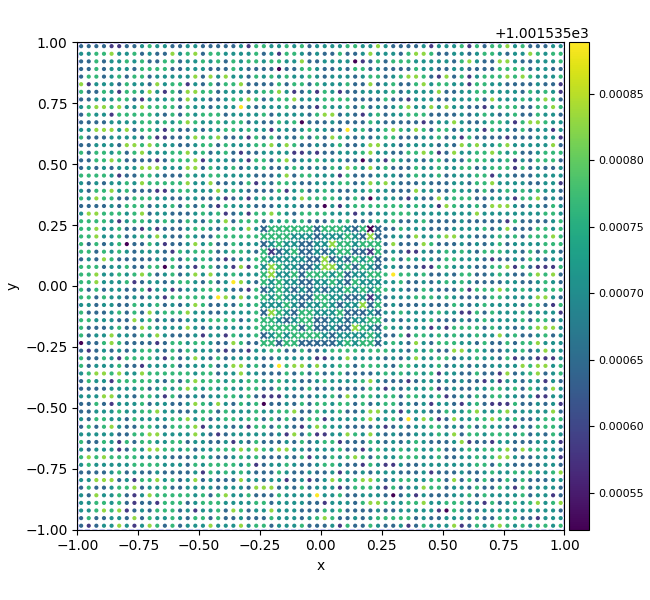

In [11]:
visualizationState = prepVisualizationState(state, config)

fig, axis = plt.subplots(1, 1, figsize=(6.5,6), sharex = False, sharey = True, squeeze = False)

plotIndex = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, (fluidDensity, boundaryDensity), which = 'all', scaling = 'lin')
# updatePlot(plotIndex, visualizationState, 'densities')

fig.tight_layout()

In [12]:
(1,2,3) + (4,5,6)

(1, 2, 3, 4, 5, 6)

In [48]:

with record_function("[SPH] - deltaSPH (2 - Normalization Matrices)"):
    Mfluid, _ = callModule(state, computeCovarianceMatrices, config, 'fluidwBoundary')
    state['fluid']['L'], state['fluid']['L.EVs'] = pinv2x2(Mfluid)


btf_gradRho, _ = callModule(state, densityGradient, config, 'boundaryToFluid')
state['fluid']['gradRho'], state['boundary']['gradRho'] = callModule(state, densityGradient, config, 'all')

state['fluid']['gradRho^L'],_ = callModule(state, renormalizedDensityGradient, config, 'fluid')

state['fluid']['densityDiffusion'], state['boundary']['densityDiffusion'] = callModule(state, computeDensityDeltaTerm, config, 'all', schemeOverride = 'densityOnly')
# if config['diffusion']['densityScheme'] == 'deltaSPH':
#     fluidDeltaTerm, _ = callModule(state, computeDensityDeltaTerm, config, 'fluid', schemeOverride = 'deltaOnly')
#     _, boundaryDeltaTerm = callModule(state, computeDensityDeltaTerm, config, 'boundary', schemeOverride = 'denormalizedOnly')
#     state['fluid']['densityDiffusion'] += fluidDeltaTerm
#     state['boundary']['densityDiffusion'] += boundaryDeltaTerm
# if config['diffusion']['densityScheme'] == 'denormalized':
fluidDeltaTerm, boundaryDeltaTerm = callModule(state, computeDensityDeltaTerm, config, 'all', schemeOverride = 'denormalizedOnly')
state['fluid']['densityDiffusion'] += fluidDeltaTerm
state['boundary']['densityDiffusion'] += boundaryDeltaTerm

In [99]:
k = 2.0 * np.pi
state['fluid']['densities'] = config['fluid']['rho0'] * (2 + torch.cos(k * state['fluid']['positions'][:,0]) * torch.cos(k * state['fluid']['positions'][:,1]))
state['boundary']['densities'] = config['fluid']['rho0'] * (2 + torch.cos(k * state['boundary']['positions'][:,0]) * torch.cos(k * state['boundary']['positions'][:,1]))


state['fluid']['densities'][:] = config['fluid']['rho0']
state['boundary']['densities'][:] = 4 * config['fluid']['rho0']

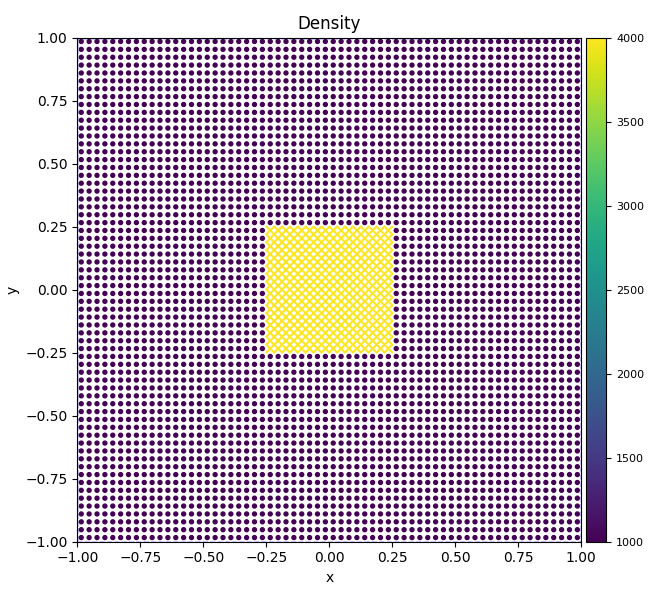

In [100]:
visualizationState = prepVisualizationState(state, config)
s = 8
fig, axis = plt.subplots(1, 1, figsize=(6.5,6), sharex = False, sharey = True, squeeze = False)

state['fluid']['gradRho'], state['boundary']['gradRho'] = callModule(state, densityGradient, config, 'all')

plotIndex = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, 'densities', which = 'all', scaling = 'lin',s = s)
# plotIndex = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, 'gradRho', mapping = '.x', which = 'all', scaling = 'lin',s = s)
# plotIndex = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, 'gradRho', mapping = '.y',which = 'all', scaling = 'lin',s = s)

axis[0,0].set_title('Density')
# axis[0,1].set_title('Density Gradient X')
# axis[0,2].set_title('Density Gradient Y')


fig.tight_layout()

In [101]:
for i in tqdm(range(512)):        
    with record_function("[SPH] - deltaSPH (2 - Normalization Matrices)"):
        Mfluid, _ = callModule(state, computeCovarianceMatrices, config, 'fluidwBoundary')
        state['fluid']['L'], state['fluid']['L.EVs'] = pinv2x2(Mfluid)


    btf_gradRho, _ = callModule(state, densityGradient, config, 'boundaryToFluid')
    state['fluid']['gradRho'], state['boundary']['gradRho'] = callModule(state, densityGradient, config, 'all')

    state['fluid']['gradRho^L'],_ = callModule(state, renormalizedDensityGradient, config, 'fluid')

    state['fluid']['densityDiffusion'], state['boundary']['densityDiffusion'] = callModule(state, computeDensityDeltaTerm, config, 'all', schemeOverride = 'densityOnly')
    # if config['diffusion']['densityScheme'] == 'deltaSPH':
    #     fluidDeltaTerm, _ = callModule(state, computeDensityDeltaTerm, config, 'fluid', schemeOverride = 'deltaOnly')
    #     _, boundaryDeltaTerm = callModule(state, computeDensityDeltaTerm, config, 'boundary', schemeOverride = 'denormalizedOnly')
    #     state['fluid']['densityDiffusion'] += fluidDeltaTerm
    #     state['boundary']['densityDiffusion'] += boundaryDeltaTerm
    # if config['diffusion']['densityScheme'] == 'denormalized':
    fluidDeltaTerm, boundaryDeltaTerm = callModule(state, computeDensityDeltaTerm, config, 'all', schemeOverride = 'denormalizedOnly')
    state['fluid']['densityDiffusion'] += fluidDeltaTerm
    state['boundary']['densityDiffusion'] += boundaryDeltaTerm

    state['fluid']['densities'] += 0.01 * state['fluid']['densityDiffusion']
    state['boundary']['densities'] += 0.01 * state['boundary']['densityDiffusion']
    if i%16 == 0:
        visualizationState = prepVisualizationState(state, config)
        updatePlot(plotIndex, visualizationState, 'densities')

        fig.canvas.draw()
        fig.canvas.flush_events()

  0%|          | 0/512 [00:00<?, ?it/s]

In [ ]:

# def simulationStep(simulationState, config):
#     with record_function("[SPH] - deltaSPH"):
#         with record_function("[SPH] - deltaSPH (1 - Neighbor Search)"):
#             simulationState['fluidNeighborhood'] = fluidNeighborSearch(simulationState, config)
#             _, simulationState['fluidNumNeighbors'] = countUniqueEntries(simulationState['fluidNeighborhood']['indices'][0], simulationState['fluidPositions'])
        
#         with record_function("[SPH] - deltaSPH (2 - Normalization Matrices)"):
#             simulationState['fluidL'], _, simulationState['L.EVs'] = computeNormalizationMatrices(simulationState, config)
#             simulationState['fluidGradRho^L'] = renormalizedDensityGradient(simulationState, config)
#         # simulationState['fluidGradRho'] = sphOperationStates(stateA, stateB, (simulationState['fluidDensities'], simulationState['fluidDensities']), operation = 'gradient', gradientMode='difference')
        
#         with record_function("[SPH] - deltaSPH (3 - Diffusion)"):
#             simulationState['fluidDensityDiffusion'] = computeDensityDeltaTerm(simulationState, config)
#             simulationState['fluidVelocityDiffusion'] = computeViscosity(simulationState, config)

#         with record_function("[SPH] - deltaSPH (4 - Momentum + Pressure)"):
#             simulationState['fluidMomentumEquation'] = computeMomentumEquation(simulationState, config)
#             simulationState['fluidPressures'] = computeEOS(simulationState, config)

#             if config['deltaSPH']['pressureSwitch']:
#                 # simulationState['fluidNormals'], simulationState['fluidLambdas'] = computeNormalsMaronne(simulationState, config)
#                 simulationState['fluidFreeSurface']= detectFreeSurfaceBarecasco(simulationState, config)
#                 (i,j) = simulationState['fluidNeighborhood']['indices']
#                 numParticles = simulationState['numParticles']
#                 simulationState['fluidSurfaceMask'] = scatter_sum(simulationState['fluidFreeSurface'][j], i, dim = 0, dim_size = numParticles)
#                 simulationState['fluidPressureAccel'] = computePressureAccelSwitch(simulationState, config)
#             else:
#                 simulationState['fluidPressureAccel'] = computePressureAccel(simulationState, config)

#         with record_function("[SPH] - deltaSPH (5 - Compute Divergence)"):
#             simulationState['fluidDivergence'] = sphOperationStates(stateA, stateB, (simulationState['fluidVelocities'], simulationState['fluidVelocities']), 'divergence')
#         with record_function("[SPH] - deltaSPH (6 - Gravity)"):
#             simulationState['fluidGravityAccel'] = computeGravity(simulationState, config)
#         if config['SPS']['active']:
#             with record_function("[SPH] - deltaSPH (7 - SPS Turbulence)"):
#                 simulationState['fluidSPSTurbulence'] = computeSPSTurbulence(simulationState, config)
#                 simulationState['fluidVelocityDiffusion'] += simulationState['fluidSPSTurbulence']

#         with record_function("[SPH] - deltaSPH (8 - Update)"):
#             dudt = simulationState['fluidPressureAccel'] + simulationState['fluidGravityAccel'] + simulationState['fluidVelocityDiffusion']
#             drhodt = simulationState['fluidMomentumEquation'] + simulationState['fluidDensityDiffusion']
            
#             return simulationState['fluidVelocities'].clone(), dudt, drhodt

# from diffSPH.parameter import Parameter
# def getParameters():
#     return [
#         Parameter('deltaSPH', 'pressureSwitch', bool, False, required = False, export = True, hint = 'Switches the pressure force calculation to the Antuono Correction'),
#     ]